In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate

from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
#ensure that TensorFlow can access local GPUs

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


In [8]:
#Loading Data

# Load data from the first CSV file
file_path1 = 'data/windowed_sequences/W_buffer/one_series_small_set_enmo_windowed_W100_B0.csv'

file_path2 = 'data/windowed_sequences/W_buffer/one_series_small_set_anglez_windowed_W100_B0.csv'

In [9]:


file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]
file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
file2_data = pd.read_csv(file_path2)

file2_array = file2_data.drop(columns=drop_columns).values

data_identity_storage = file1_data[["series_id", "global first step num", "global first timestamp"]]
df_Y = file1_data.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
assert file1_array.shape == file2_array.shape, "Arrays should have the same shape"

# Create 3D array
three_d_array = np.stack([file1_array, file2_array], axis=2)


In [10]:
# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)

indices_train shape: 323344
X_train shape: (323344, 100, 2)
y_train shape: (323344, 4)
indices_val shape: 80837
X_val shape: (80837, 100, 2)
y_val shape: (80837, 4)


In [ ]:
'''
# Adjust the size of the subset based on your computational resources
subset_percentage = 10
subset_size = X_train.shape[0] // 100 * subset_percentage

# Split the data into a subset and the rest
subset_X, remaining_X, subset_Y, remaining_Y = train_test_split(X_train, Y_train, test_size=subset_size, random_state=42, stratify=Y_train)

# Confirm the shapes of the subsets
print("Subset X shape:", subset_X.shape)
print("Remaining X shape:", remaining_X.shape)
print("Subset y shape:", subset_Y.shape)
print("Remaining y shape:", remaining_Y.shape)
'''

In [12]:
#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=64, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10106/10106 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.5753
Epoch 1: val_loss improved from inf to 0.99784, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 152s 15ms/step - loss: 1.0309 - accuracy: 0.5753 - val_loss: 0.9978 - val_accuracy: 0.5590
Epoch 2/20
    9/10106 [..............................] - ETA: 2:30 - loss: 1.0341 - accuracy: 0.5382

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10106 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.6937
Epoch 2: val_loss improved from 0.99784 to 0.89940, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 161s 16ms/step - loss: 0.7774 - accuracy: 0.6937 - val_loss: 0.8994 - val_accuracy: 0.6554
Epoch 3/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.7309
Epoch 3: val_loss improved from 0.89940 to 0.76174, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 163s 16ms/step - loss: 0.6868 - accuracy: 0.7309 - val_loss: 0.7617 - val_accuracy: 0.7188
Epoch 4/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.6339 - accuracy: 0.7578
Epoch 4: val_loss improved from 0.76174 to 0.67036, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 166s 16ms/step - loss: 0.6339 - accuracy: 0.7578 - val_

In [11]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention_W100_B0.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10105/10105 [==============================] - ETA: 0s - loss: 0.8694 - accuracy: 0.6614
Epoch 1: val_loss improved from inf to 0.69713, saving model to model\model_one_series_LSTM128_W_attention_W100_B0.h5
10105/10105 [==============================] - 524s 52ms/step - loss: 0.8694 - accuracy: 0.6614 - val_loss: 0.6971 - val_accuracy: 0.7508
Epoch 2/20
    3/10105 [..............................] - ETA: 7:55 - loss: 0.3724 - accuracy: 0.6875

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10105 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.7899
Epoch 2: val_loss improved from 0.69713 to 0.58867, saving model to model\model_one_series_LSTM128_W_attention_W100_B0.h5
10105/10105 [==============================] - 566s 56ms/step - loss: 0.5395 - accuracy: 0.7899 - val_loss: 0.5887 - val_accuracy: 0.8017
Epoch 3/20
10105/10105 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8388
Epoch 3: val_loss improved from 0.58867 to 0.44882, saving model to model\model_one_series_LSTM128_W_attention_W100_B0.h5
10105/10105 [==============================] - 608s 60ms/step - loss: 0.4325 - accuracy: 0.8388 - val_loss: 0.4488 - val_accuracy: 0.8574
Epoch 4/20
10104/10105 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8601
Epoch 4: val_loss improved from 0.44882 to 0.34592, saving model to model\model_one_series_LSTM128_W_attention_W100_B0.h5
10105/10105 [==============================] - 639s 63ms/step - loss:

In [9]:
loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

loaded_model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


Epoch 1/20
10106/10106 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8244
Epoch 1: val_loss improved from inf to 0.64284, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 411s 41ms/step - loss: 0.4708 - accuracy: 0.8244 - val_loss: 0.6428 - val_accuracy: 0.7562
Epoch 2/20
    3/10106 [..............................] - ETA: 4:55 - loss: 0.2779 - accuracy: 0.7500

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10106/10106 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.64284 to 0.55632, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 420s 42ms/step - loss: 0.4515 - accuracy: 0.8334 - val_loss: 0.5563 - val_accuracy: 0.7928
Epoch 3/20
10104/10106 [============================>.] - ETA: 1s - loss: 0.4421 - accuracy: 0.8442
Epoch 3: val_loss improved from 0.55632 to 0.53572, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 7457s 738ms/step - loss: 0.4424 - accuracy: 0.8442 - val_loss: 0.5357 - val_accuracy: 0.8068
Epoch 4/20
10104/10106 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.8484
Epoch 4: val_loss improved from 0.53572 to 0.52055, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 260s 26ms/step - loss: 0.4278 - accuracy: 0.8484 - va

In [10]:
loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

loaded_model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


Epoch 1/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4708 - accuracy: 0.8244
Epoch 1: val_loss improved from inf to 0.64284, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 248s 24ms/step - loss: 0.4708 - accuracy: 0.8244 - val_loss: 0.6428 - val_accuracy: 0.7562
Epoch 2/20
    6/10106 [..............................] - ETA: 4:12 - loss: 0.3416 - accuracy: 0.7344

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10106 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.64284 to 0.55632, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 257s 25ms/step - loss: 0.4515 - accuracy: 0.8334 - val_loss: 0.5563 - val_accuracy: 0.7928
Epoch 3/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8442
Epoch 3: val_loss improved from 0.55632 to 0.53572, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 257s 25ms/step - loss: 0.4424 - accuracy: 0.8442 - val_loss: 0.5357 - val_accuracy: 0.8068
Epoch 4/20
10105/10106 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8484
Epoch 4: val_loss improved from 0.53572 to 0.52055, saving model to model\model_one_series_LSTM_W_attention.h5
10106/10106 [==============================] - 267s 26ms/step - loss: 0.4278 - accuracy: 0.8484 - val_

In [11]:
#LSTM = 32

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=32, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM32_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/30
10102/10106 [============================>.] - ETA: 0s - loss: 1.1102 - accuracy: 0.5321
Epoch 1: val_loss improved from inf to 1.10313, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 118s 12ms/step - loss: 1.1102 - accuracy: 0.5321 - val_loss: 1.1031 - val_accuracy: 0.4972
Epoch 2/30
   15/10106 [..............................] - ETA: 2:05 - loss: 0.7805 - accuracy: 0.4458

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10106 [============================>.] - ETA: 0s - loss: 0.9114 - accuracy: 0.6257
Epoch 2: val_loss improved from 1.10313 to 1.00430, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.9114 - accuracy: 0.6257 - val_loss: 1.0043 - val_accuracy: 0.5861
Epoch 3/30
10103/10106 [============================>.] - ETA: 0s - loss: 0.7854 - accuracy: 0.6882
Epoch 3: val_loss improved from 1.00430 to 0.83949, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 118s 12ms/step - loss: 0.7855 - accuracy: 0.6882 - val_loss: 0.8395 - val_accuracy: 0.6416
Epoch 4/30
10104/10106 [============================>.] - ETA: 0s - loss: 0.7302 - accuracy: 0.7150
Epoch 4: val_loss improved from 0.83949 to 0.76207, saving model to model\model_one_series_LSTM32_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.7304 - accuracy: 0.7150 

In [12]:
#LSTM = 256

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=32, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM256_W_attention.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=30, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/30
10106/10106 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.5377
Epoch 1: val_loss improved from inf to 1.16018, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 119s 12ms/step - loss: 1.0771 - accuracy: 0.5377 - val_loss: 1.1602 - val_accuracy: 0.4150
Epoch 2/30
   11/10106 [..............................] - ETA: 1:53 - loss: 0.8809 - accuracy: 0.4119

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10102/10106 [============================>.] - ETA: 0s - loss: 0.8545 - accuracy: 0.6343
Epoch 2: val_loss improved from 1.16018 to 0.96351, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.8546 - accuracy: 0.6343 - val_loss: 0.9635 - val_accuracy: 0.6134
Epoch 3/30
10104/10106 [============================>.] - ETA: 0s - loss: 0.7542 - accuracy: 0.6829
Epoch 3: val_loss improved from 0.96351 to 0.81235, saving model to model\model_one_series_LSTM256_W_attention.h5
10106/10106 [==============================] - 117s 12ms/step - loss: 0.7544 - accuracy: 0.6829 - val_loss: 0.8123 - val_accuracy: 0.6334
Epoch 4/30
10103/10106 [============================>.] - ETA: 0s - loss: 0.6825 - accuracy: 0.7237
Epoch 4: val_loss did not improve from 0.81235
10106/10106 [==============================] - 118s 12ms/step - loss: 0.6827 - accuracy: 0.7237 - val_loss: 1.0416 - val_accuracy: 0.5479
Epoch 5/30
10102/10106

2527/2527 [==============================] - 17s 7ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       47826    1189         623    3499
wakeup          2     170           4      49
fallasleep     11       5         195      14
asleep       1514    4380         965   20401


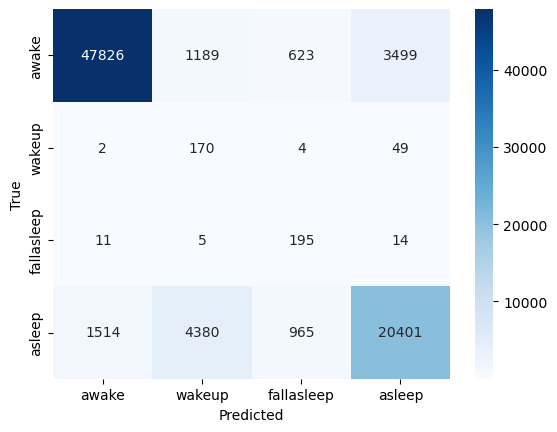

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


2527/2527 [==============================] - 37s 15ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       49422     639         229    2699
wakeup          0     334           0      29
fallasleep      1       3         335      24
asleep        693    1223         132   25074


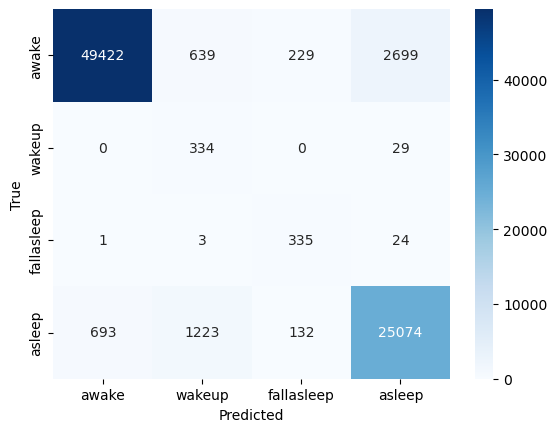

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W100_B10.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


2527/2527 [==============================] - 57s 23ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       49967     324         123    2483
wakeup          5     395           2      53
fallasleep      7       6         415      27
asleep        668     791         159   25412


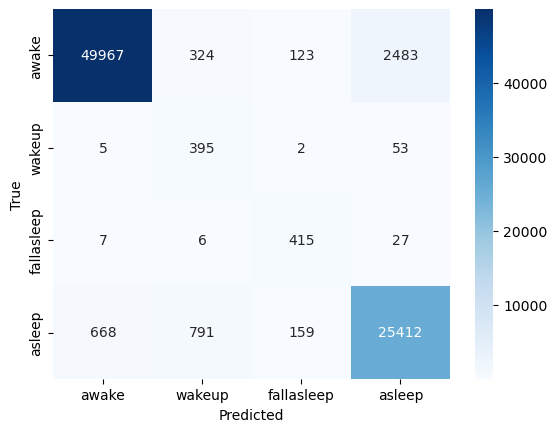

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W100_B0.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [13]:
#Loading Data

# Load data from the first CSV file
file_path1 = 'data/windowed_sequences/W_buffer/one_series_small_set_enmo_windowed_W100_B20.csv'

file_path2 = 'data/windowed_sequences/W_buffer/one_series_small_set_anglez_windowed_W100_B20.csv'



file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]
file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
file2_data = pd.read_csv(file_path2)

file2_array = file2_data.drop(columns=drop_columns).values

data_identity_storage = file1_data[["series_id", "global first step num", "global first timestamp"]]
df_Y = file1_data.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
assert file1_array.shape == file2_array.shape, "Arrays should have the same shape"

# Create 3D array
three_d_array = np.stack([file1_array, file2_array], axis=2)

# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)


indices_train shape: 323344
X_train shape: (323344, 100, 2)
y_train shape: (323344, 4)
indices_val shape: 80837
X_val shape: (80837, 100, 2)
y_val shape: (80837, 4)


In [14]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention_W100_B20.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10104/10105 [============================>.] - ETA: 0s - loss: 0.8684 - accuracy: 0.6545
Epoch 1: val_loss improved from inf to 0.75349, saving model to model\model_one_series_LSTM128_W_attention_W100_B20.h5
10105/10105 [==============================] - 637s 63ms/step - loss: 0.8684 - accuracy: 0.6545 - val_loss: 0.7535 - val_accuracy: 0.7309
Epoch 2/20
    2/10105 [..............................] - ETA: 9:04 - loss: 0.3693 - accuracy: 0.7656 

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10104/10105 [============================>.] - ETA: 0s - loss: 0.4939 - accuracy: 0.8011
Epoch 2: val_loss improved from 0.75349 to 0.50841, saving model to model\model_one_series_LSTM128_W_attention_W100_B20.h5
10105/10105 [==============================] - 613s 61ms/step - loss: 0.4939 - accuracy: 0.8011 - val_loss: 0.5084 - val_accuracy: 0.8215
Epoch 3/20
10105/10105 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8400
Epoch 3: val_loss did not improve from 0.50841
10105/10105 [==============================] - 528s 52ms/step - loss: 0.3908 - accuracy: 0.8400 - val_loss: 0.5221 - val_accuracy: 0.8169
Epoch 4/20
10104/10105 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8606
Epoch 4: val_loss improved from 0.50841 to 0.39269, saving model to model\model_one_series_LSTM128_W_attention_W100_B20.h5
10105/10105 [==============================] - 519s 51ms/step - loss: 0.3520 - accuracy: 0.8606 - val_loss: 0.3927 - val_accuracy: 0.8673
Epoc

2527/2527 [==============================] - 50s 20ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       49717     423         335    2606
wakeup          0     256           0      15
fallasleep      0       1         265       5
asleep       1145     688         734   24647


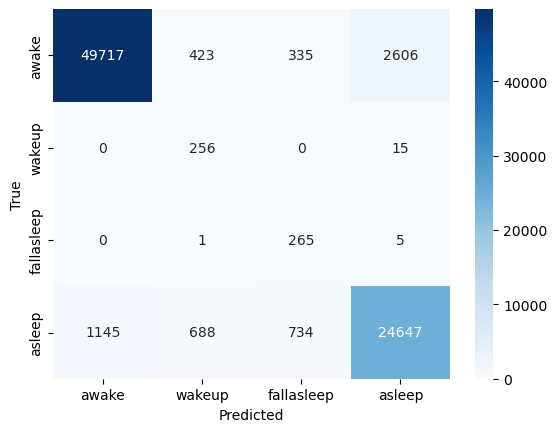

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W100_B20.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
#Loading Data

# Load data from the first CSV file
file_path1 = 'data/windowed_sequences/W_buffer/one_series_small_set_enmo_windowed_W100_B30.csv'

file_path2 = 'data/windowed_sequences/W_buffer/one_series_small_set_anglez_windowed_W100_B30.csv'



file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]
file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
file2_data = pd.read_csv(file_path2)

file2_array = file2_data.drop(columns=drop_columns).values

data_identity_storage = file1_data[["series_id", "global first step num", "global first timestamp"]]
df_Y = file1_data.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
assert file1_array.shape == file2_array.shape, "Arrays should have the same shape"

# Create 3D array
three_d_array = np.stack([file1_array, file2_array], axis=2)

# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)


indices_train shape: 323344
X_train shape: (323344, 100, 2)
y_train shape: (323344, 4)
indices_val shape: 80837
X_val shape: (80837, 100, 2)
y_val shape: (80837, 4)


In [17]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention_W100_B30.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10105/10105 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.6432
Epoch 1: val_loss improved from inf to 0.74283, saving model to model\model_one_series_LSTM128_W_attention_W100_B30.h5
10105/10105 [==============================] - 984s 97ms/step - loss: 0.8741 - accuracy: 0.6432 - val_loss: 0.7428 - val_accuracy: 0.7476
Epoch 2/20
    1/10105 [..............................] - ETA: 20:10 - loss: 0.5213 - accuracy: 0.7188

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10105/10105 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7873
Epoch 2: val_loss improved from 0.74283 to 0.52195, saving model to model\model_one_series_LSTM128_W_attention_W100_B30.h5
10105/10105 [==============================] - 1227s 121ms/step - loss: 0.5156 - accuracy: 0.7873 - val_loss: 0.5220 - val_accuracy: 0.8189
Epoch 3/20
10105/10105 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8315
Epoch 3: val_loss improved from 0.52195 to 0.42941, saving model to model\model_one_series_LSTM128_W_attention_W100_B30.h5
10105/10105 [==============================] - 1238s 122ms/step - loss: 0.3969 - accuracy: 0.8315 - val_loss: 0.4294 - val_accuracy: 0.8506
Epoch 4/20
10105/10105 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8518
Epoch 4: val_loss improved from 0.42941 to 0.35759, saving model to model\model_one_series_LSTM128_W_attention_W100_B30.h5
10105/10105 [==============================] - 1057s 105ms/ste

2527/2527 [==============================] - 91s 36ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       46694     954         838    4687
wakeup          5     164           0      10
fallasleep      4       0         164      11
asleep       1537     955         785   24029


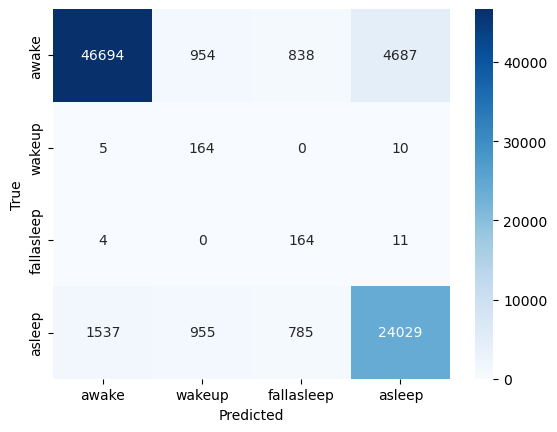

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W100_B30.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [19]:
#Loading Data

# Load data from the first CSV file
file_path1 = 'data/windowed_sequences/W_buffer/one_series_small_set_enmo_windowed_W200_B20.csv'

file_path2 = 'data/windowed_sequences/W_buffer/one_series_small_set_anglez_windowed_W200_B20.csv'



file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]
file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
file2_data = pd.read_csv(file_path2)

file2_array = file2_data.drop(columns=drop_columns).values

data_identity_storage = file1_data[["series_id", "global first step num", "global first timestamp"]]
df_Y = file1_data.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
assert file1_array.shape == file2_array.shape, "Arrays should have the same shape"

# Create 3D array
three_d_array = np.stack([file1_array, file2_array], axis=2)

# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)


indices_train shape: 323264
X_train shape: (323264, 200, 2)
y_train shape: (323264, 4)
indices_val shape: 80817
X_val shape: (80817, 200, 2)
y_val shape: (80817, 4)


In [20]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention_W200_B20.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10102/10102 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7163
Epoch 1: val_loss improved from inf to 0.58115, saving model to model\model_one_series_LSTM128_W_attention_W200_B20.h5
10102/10102 [==============================] - 1798s 178ms/step - loss: 0.6639 - accuracy: 0.7163 - val_loss: 0.5811 - val_accuracy: 0.7941
Epoch 2/20
    1/10102 [..............................] - ETA: 23:04 - loss: 0.1251 - accuracy: 0.9375

C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10102/10102 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8567
Epoch 2: val_loss improved from 0.58115 to 0.33230, saving model to model\model_one_series_LSTM128_W_attention_W200_B20.h5
10102/10102 [==============================] - 1666s 165ms/step - loss: 0.3379 - accuracy: 0.8567 - val_loss: 0.3323 - val_accuracy: 0.8875
Epoch 3/20
10102/10102 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8803
Epoch 3: val_loss did not improve from 0.33230
10102/10102 [==============================] - 1522s 151ms/step - loss: 0.2885 - accuracy: 0.8803 - val_loss: 0.3718 - val_accuracy: 0.8741
Epoch 4/20
10102/10102 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9111
Epoch 4: val_loss improved from 0.33230 to 0.25044, saving model to model\model_one_series_LSTM128_W_attention_W200_B20.h5
10102/10102 [==============================] - 1551s 154ms/step - loss: 0.2141 - accuracy: 0.9111 - val_loss: 0.2504 - val_accuracy: 0.915

2526/2526 [==============================] - 138s 55ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       51027     104         113    1357
wakeup          2     702           0      27
fallasleep      4       0         711      16
asleep        279     146          74   26255


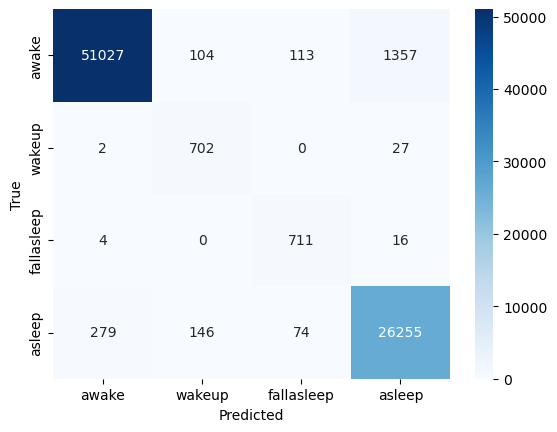

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W200_B20.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [22]:
#Loading Data

# Load data from the first CSV file
file_path1 = 'data/windowed_sequences/W_buffer/one_series_small_set_enmo_windowed_W400_B40.csv'

file_path2 = 'data/windowed_sequences/W_buffer/one_series_small_set_anglez_windowed_W400_B40.csv'



file1_data = pd.read_csv(file_path1)#, dtype=np.float32)

# Set the first column as the index
#file1_data.set_index(file1_data.columns[0], inplace=True)

# Convert the DataFrame to a NumPy array
drop_columns = ["series_id", "global first step num", "global first timestamp", "awake","wakeup","fallasleep","asleep"]
file1_array = file1_data.drop(columns=drop_columns).values

# Load data from the second CSV file
file2_data = pd.read_csv(file_path2)

file2_array = file2_data.drop(columns=drop_columns).values

data_identity_storage = file1_data[["series_id", "global first step num", "global first timestamp"]]
df_Y = file1_data.iloc[:, -4:]
Y_all = df_Y.values
# Check shapes
assert file1_array.shape == file2_array.shape, "Arrays should have the same shape"

# Create 3D array
three_d_array = np.stack([file1_array, file2_array], axis=2)

# Extract indices from the original 3D array
indices_list = list(range(three_d_array.shape[0]))

# Split the data and indices into training and validation sets
indices_train, indices_val, X_train, X_val, Y_train, Y_val = train_test_split(
    indices_list, three_d_array, Y_all, test_size=0.2, random_state=42, stratify=Y_all
)

# Check the shapes of the training and validation sets
print("indices_train shape:", len(indices_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("indices_val shape:", len(indices_val))
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)


indices_train shape: 323104
X_train shape: (323104, 400, 2)
y_train shape: (323104, 4)
indices_val shape: 80777
X_val shape: (80777, 400, 2)
y_val shape: (80777, 4)


In [23]:
#LSTM = 128

#for tuning model configuration
dataset_for_training = X_train
labels_for_training = Y_train
num_classes = labels_for_training.shape[1]

# Assuming you have sequences (X) and labels (y) for training
# X should be a 3D tensor with shape (num_samples, sequence_length, num_features)
# y should be a 2D tensor with shape (num_samples, num_classes)

sequence_length = dataset_for_training.shape[1]
num_features = dataset_for_training.shape[2]

# Define the LSTM model
input_sequence = Input(shape=(sequence_length, num_features))
#lstm_out = LSTM(units=64, return_sequences=True)(input_sequence)
lstm_out = LSTM(units=128, return_sequences=False, recurrent_initializer='glorot_uniform', implementation=2)(input_sequence)


# Define the attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Concatenate the LSTM output and attention output
merged = Concatenate(axis=-1)([lstm_out, attention])

# Fully connected layer for final prediction
output = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model = Model(inputs=input_sequence, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(labels_for_training, axis=1)), y=np.argmax(labels_for_training, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/model_one_series_LSTM128_W_attention_W400_B40.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
    options=None  # Set options explicitly to None
)

# Train the model with class weights, early stopping, and TensorBoard
#model.fit(subset_X, subset_Y, epochs=10, batch_size=32, validation_data=(X_val, Y_val), class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard])
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_for_training, labels_for_training)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(32)

model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[early_stopping, tensorboard, checkpoint])


# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
10097/10097 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.7887
Epoch 1: val_loss improved from inf to 0.46946, saving model to model\model_one_series_LSTM128_W_attention_W400_B40.h5
10097/10097 [==============================] - 3270s 324ms/step - loss: 0.4672 - accuracy: 0.7887 - val_loss: 0.4695 - val_accuracy: 0.8357
Epoch 2/20


C:\Users\19252\.conda\envs\research\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10097/10097 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9033
Epoch 2: val_loss improved from 0.46946 to 0.24628, saving model to model\model_one_series_LSTM128_W_attention_W400_B40.h5
10097/10097 [==============================] - 3578s 354ms/step - loss: 0.2254 - accuracy: 0.9033 - val_loss: 0.2463 - val_accuracy: 0.9193
Epoch 3/20
10097/10097 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9240
Epoch 3: val_loss improved from 0.24628 to 0.16061, saving model to model\model_one_series_LSTM128_W_attention_W400_B40.h5
10097/10097 [==============================] - 2507s 248ms/step - loss: 0.1739 - accuracy: 0.9240 - val_loss: 0.1606 - val_accuracy: 0.9494
Epoch 4/20
10097/10097 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9384
Epoch 4: val_loss improved from 0.16061 to 0.10109, saving model to model\model_one_series_LSTM128_W_attention_W400_B40.h5
10097/10097 [==============================] - 3426s 339ms/ste

2525/2525 [==============================] - 399s 158ms/step
Confusion Matrix:
            awake  wakeup  fallasleep  asleep
awake       50606     274         107     838
wakeup          0    1448           0      19
fallasleep      3       1        1459       4
asleep        148     133         181   25556


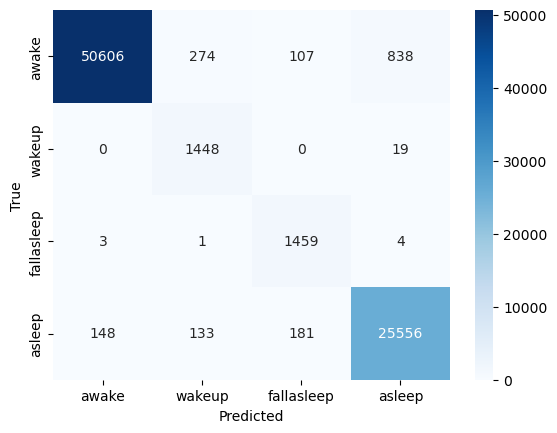

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

loaded_model = load_model('model/model_one_series_LSTM128_W_attention_W400_B40.h5')
class_labels = ["awake","wakeup","fallasleep","asleep"]

# Assuming you have trained your model and obtained predictions on the validation set
# Replace 'loaded_model' with the actual reference to your trained model

# Assuming X_val and Y_val are your validation data
y_true = np.argmax(Y_val, axis=1)
y_pred = loaded_model.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Display the confusion matrix as a table
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
